<h1><center><font size="6">Cats or Dogs - using CNN with Transfer Learning</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages and set parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Prepare submission</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>



# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **25,000** images of **dogs** and **cats**. Each image in this folder has the label as part of the filename. The **test** folder contains **12,500** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **dog**, **0** = **cat**).


## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

# <a id="2">Load packages</a>

In [1]:
!python3 --version

Python 3.6.6 :: Anaconda, Inc.


In [2]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

Using TensorFlow backend.


In [3]:
 !pip show tensorflow

Name: tensorflow
Version: 1.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /opt/conda/lib/python3.6/site-packages
Requires: numpy, keras-preprocessing, protobuf, keras-applications, setuptools, absl-py, wheel, grpcio, six, gast, tensorboard, astor, termcolor
Required-by: fancyimpute, ethnicolr


In [4]:
!pip show keras

Name: Keras
Version: 2.2.2
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: numpy, six, keras-preprocessing, pyyaml, keras-applications, h5py, scipy
Required-by: keras-tqdm, ethnicolr


## Parameters

Here we set few parameters used in the model. The image size is **224**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Dog** and **Cat**.  
We will use a subset of the training data set (**20,000** images).  From the training set, **50%** will be used for training, **50%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



# <a id="3">Read the data</a>

We set the train image list.   
Setting the **SAMPLE_SIZE** value we can reduce/enlarge the size of the training set.    
Currently **SAMPLE_SIZE** is set to **20,000**.


In [5]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
train_image_path = os.path.join(PATH, "train.zip")
print(train_image_path)
test_image_path = os.path.join(PATH, "test.zip")
print(test_image_path)

/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [7]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [8]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [9]:
count = 0
train_image_list = os.listdir("./train/")[0:SAMPLE_SIZE]
while count < 10:
    print(f"train: {train_image_list[count]}")
    count+=1
count = 0
test_image_list = os.listdir("./test/")
while count <= 10:
    print(f"test: {test_image_list[count]}")
    count+=1

train: cat.7113.jpg
train: dog.8778.jpg
train: dog.644.jpg
train: dog.6964.jpg
train: cat.11267.jpg
train: dog.11246.jpg
train: dog.4255.jpg
train: dog.2248.jpg
train: cat.10693.jpg
train: dog.11429.jpg
test: 7042.jpg
test: 8405.jpg
test: 12171.jpg
test: 1931.jpg
test: 5040.jpg
test: 9862.jpg
test: 4883.jpg
test: 8040.jpg
test: 10856.jpg
test: 2591.jpg
test: 10752.jpg


We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either a cat or a dog. We are using one hot encoder, storing [1,0] for **cat** and [0,1] for **dog**.

In [10]:
def label_pet_image_one_hot_encoder(img):  
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [11]:
label_pet_image_one_hot_encoder("cat.9190.jpg")

[1, 0]

We are defining as well a function to process the data (both train and test set). 

In [12]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    debag = True
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        if debag: print(f"Image: {label}\nSet there is train: {isTrain}")
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if debag: print(f"img: {img}")
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
        if debag: 
            print(f"img: {img}")
            print(f"data_df: {data_df}")
        debag = False
    shuffle(data_df)
    return data_df

# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **cat**/**dog** distribution.   We show first the split in the reduced train data.

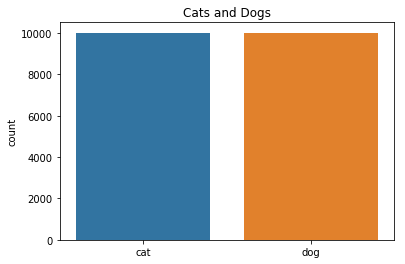

In [13]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
         labels.append(img.split('.')[-3])  # Create labels from images name
    sns.countplot(labels)  # Counte labels and visualize
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

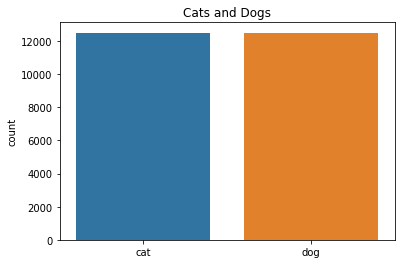

In [14]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))  # listdir - will return a list of all files and directories in the directory specified by TRAIN_FOLDER.

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

In [15]:
train = process_data(train_image_list, TRAIN_FOLDER)

  0%|          | 65/20000 [00:00<01:01, 322.37it/s]

Image: [1, 0]
Set there is train: True
img: [[[ 55  64  78]
  [ 58  67  81]
  [ 48  57  71]
  ...
  [ 20  36  43]
  [ 20  39  46]
  [ 88 107 114]]

 [[ 55  64  78]
  [ 58  67  81]
  [ 48  57  71]
  ...
  [ 23  39  46]
  [ 21  40  47]
  [ 86 105 112]]

 [[ 55  64  78]
  [ 59  68  82]
  [ 49  58  72]
  ...
  [ 16  32  39]
  [ 17  36  43]
  [ 85 104 111]]

 ...

 [[189 194 192]
  [184 189 187]
  [183 188 186]
  ...
  [187 192 191]
  [188 193 192]
  [189 194 193]]

 [[188 193 191]
  [183 188 186]
  [182 187 185]
  ...
  [180 185 184]
  [181 186 185]
  [182 187 186]]

 [[186 191 189]
  [181 186 184]
  [180 185 183]
  ...
  [180 185 184]
  [180 185 184]
  [180 185 184]]]
img: [[[ 56  65  79]
  [ 37  46  60]
  [  9  16  31]
  ...
  [ 46  57  65]
  [ 23  39  46]
  [ 54  73  80]]

 [[ 57  66  80]
  [ 37  46  60]
  [  9  16  31]
  ...
  [ 47  58  66]
  [ 20  36  43]
  [ 52  71  78]]

 [[ 57  66  80]
  [ 38  47  61]
  [ 10  18  32]
  ...
  [ 47  58  66]
  [  7  23  30]
  [ 51  70  77]]

 ...

 [[

100%|██████████| 20000/20000 [00:49<00:00, 407.69it/s]


Then, we plot the image selection.

img_num: [1 0]
img_data:[[[ 89  95  97]
  [ 25  30  30]
  [ 23  30  25]
  ...
  [180 192 196]
  [179 191 195]
  [179 191 195]]

 [[ 33  35  36]
  [ 16  19  19]
  [ 19  22  18]
  ...
  [180 192 196]
  [180 191 196]
  [180 191 196]]

 [[ 24  20  20]
  [ 30  27  27]
  [ 18  18  15]
  ...
  [180 192 196]
  [180 192 196]
  [180 192 196]]

 ...

 [[130 125 166]
  [127 118 171]
  [122 107 175]
  ...
  [211 182 184]
  [210 181 185]
  [211 180 186]]

 [[157 155 177]
  [142 137 177]
  [119 109 171]
  ...
  [208 177 194]
  [211 179 197]
  [210 179 198]]

 [[195 184 165]
  [183 171 174]
  [150 137 173]
  ...
  [211 176 204]
  [210 179 200]
  [208 180 198]]]
label: 0
str_label: Cat
img_num: [0 1]
img_data:[[[ 25  33  40]
  [ 25  33  40]
  [ 25  33  40]
  ...
  [ 51  65  98]
  [ 50  60  94]
  [ 50  60  94]]

 [[ 25  32  41]
  [ 25  32  41]
  [ 25  32  41]
  ...
  [ 47  61  94]
  [ 44  56  90]
  [ 45  55  89]]

 [[ 27  34  43]
  [ 27  34  43]
  [ 27  34  43]
  ...
  [ 46  61  94]
  [ 46  58  92]
  [ 

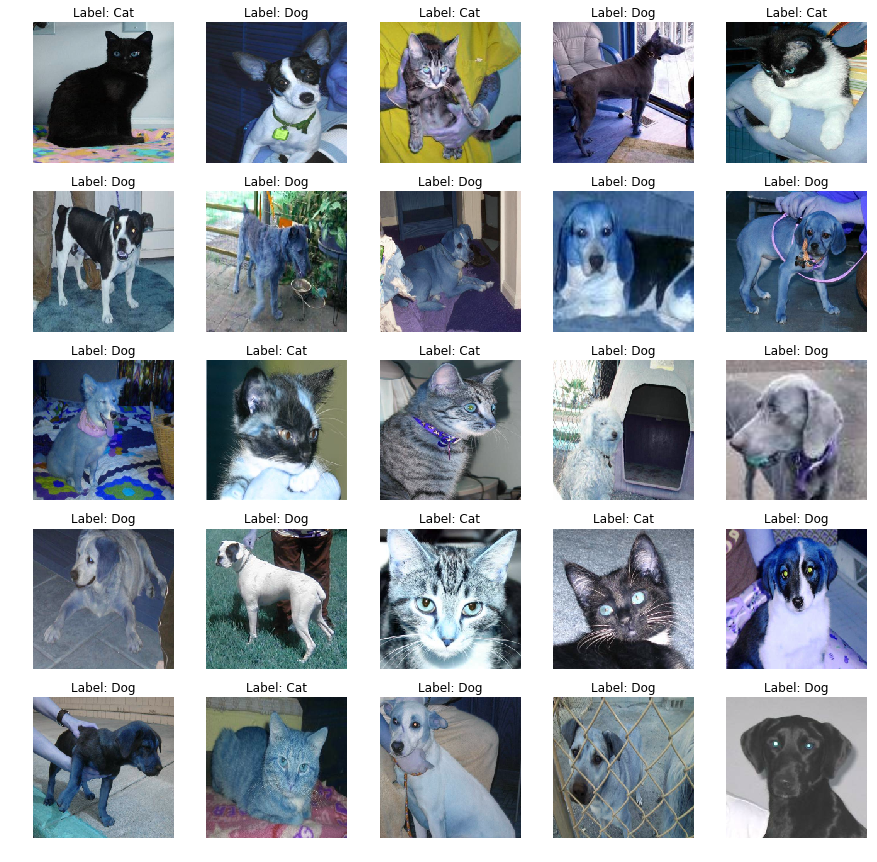

In [16]:
def show_images(data, isTest=False):
    count = 0
    # plt.subplots(5, 5) creates a 5x5 grid of subplots (i.e., 25 subplots in total).
    # f is the Figure object that contains all the subplots.
    # ax is a 2D array of Axes objects, where each Axes object corresponds to an individual subplot.
    f, ax = plt.subplots(5,5, figsize=(15,15)) 
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label="Dog"
        elif label == 0: 
            str_label="Cat"
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis("off")
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
        if count < 4:
            print(f"img_num: {img_num}\nimg_data:{img_data}\nlabel: {label}\nstr_label: {str_label}")
        count += 1
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [17]:
test = process_data(test_image_list, TEST_FOLDER, False)

  0%|          | 41/12500 [00:00<00:30, 406.56it/s]

Image: 7042
Set there is train: False
img: [[[ 22  18  17]
  [ 23  19  18]
  [ 25  21  20]
  ...
  [ 53  67  66]
  [ 53  67  66]
  [ 51  67  66]]

 [[ 26  22  21]
  [ 26  22  21]
  [ 26  22  21]
  ...
  [ 55  69  68]
  [ 55  69  68]
  [ 53  69  68]]

 [[ 28  26  26]
  [ 26  24  24]
  [ 24  22  22]
  ...
  [ 56  70  69]
  [ 55  69  68]
  [ 53  69  68]]

 ...

 [[ 77  92 118]
  [ 67  84 111]
  [ 63  80 107]
  ...
  [143 149 148]
  [140 146 145]
  [138 145 142]]

 [[ 70  84 107]
  [ 65  81 104]
  [ 65  82 108]
  ...
  [140 146 145]
  [142 148 147]
  [143 150 147]]

 [[ 70  84 106]
  [ 65  82 103]
  [ 67  82 108]
  ...
  [140 146 145]
  [144 150 149]
  [146 153 150]]]
img: [[[ 22  18  17]
  [ 22  18  17]
  [ 23  19  18]
  ...
  [ 53  67  66]
  [ 52  67  66]
  [ 51  67  66]]

 [[ 25  21  20]
  [ 25  21  20]
  [ 25  21  20]
  ...
  [ 54  68  67]
  [ 53  68  67]
  [ 52  68  67]]

 [[ 27  24  24]
  [ 27  24  23]
  [ 26  23  23]
  ...
  [ 55  69  68]
  [ 54  69  68]
  [ 53  69  68]]

 ...

 [[ 

100%|██████████| 12500/12500 [00:30<00:00, 412.64it/s]


Then, we show a selection of the test set.

img_num: 1253
img_data:[[[ 68  44  32]
  [ 55  30  19]
  [ 36  12   2]
  ...
  [ 16  11   2]
  [ 22  18   8]
  [ 27  22  12]]

 [[ 44  20   9]
  [ 53  29  17]
  [ 65  41  28]
  ...
  [ 24  20  10]
  [ 30  26  16]
  [ 34  30  20]]

 [[ 76  52  40]
  [ 86  62  50]
  [100  76  64]
  ...
  [ 18  16   6]
  [ 24  21  12]
  [ 28  25  16]]

 ...

 [[155 173 192]
  [156 175 193]
  [159 177 196]
  ...
  [126 153 179]
  [125 152 178]
  [125 152 178]]

 [[156 173 192]
  [156 173 192]
  [157 174 193]
  ...
  [125 152 178]
  [125 152 178]
  [125 152 178]]

 [[124 141 160]
  [123 140 159]
  [121 138 157]
  ...
  [125 152 178]
  [125 152 178]
  [125 152 178]]]
label: 0
str_label: None
img_num: 1225
img_data:[[[234 244 238]
  [225 235 229]
  [230 240 234]
  ...
  [237 243 238]
  [235 241 236]
  [235 241 236]]

 [[226 236 229]
  [239 249 243]
  [244 254 248]
  ...
  [233 239 234]
  [235 241 236]
  [235 241 236]]

 [[241 248 243]
  [229 236 231]
  [227 234 229]
  ...
  [232 238 233]
  [235 241 236]
  [23

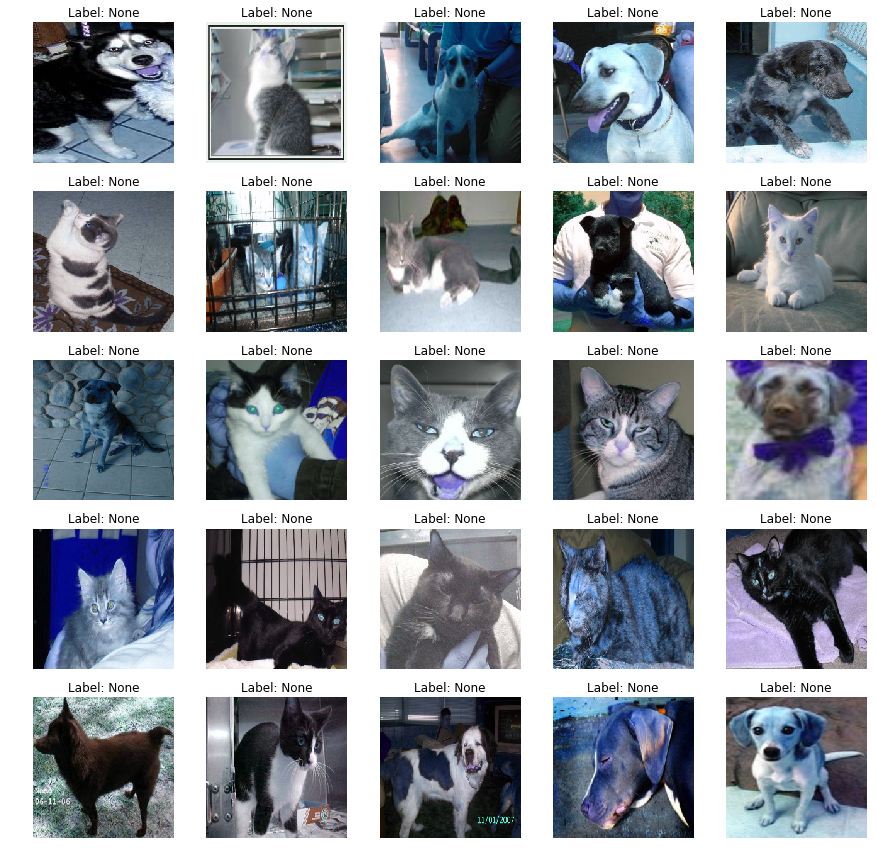

In [18]:
show_images(test,True)

# <a id="5">Model</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [19]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])
print(f"X train: {X[0]}\ny train: {y[0]}")

X train: [[[ 89  95  97]
  [ 25  30  30]
  [ 23  30  25]
  ...
  [180 192 196]
  [179 191 195]
  [179 191 195]]

 [[ 33  35  36]
  [ 16  19  19]
  [ 19  22  18]
  ...
  [180 192 196]
  [180 191 196]
  [180 191 196]]

 [[ 24  20  20]
  [ 30  27  27]
  [ 18  18  15]
  ...
  [180 192 196]
  [180 192 196]
  [180 192 196]]

 ...

 [[130 125 166]
  [127 118 171]
  [122 107 175]
  ...
  [211 182 184]
  [210 181 185]
  [211 180 186]]

 [[157 155 177]
  [142 137 177]
  [119 109 171]
  ...
  [208 177 194]
  [211 179 197]
  [210 179 198]]

 [[195 184 165]
  [183 171 174]
  [150 137 173]
  ...
  [211 176 204]
  [210 179 200]
  [208 180 198]]]
y train: [1 0]


### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [20]:
model = Sequential() # Creates a new Sequential model. This model is a linear stack of layers where you can add one layer at a time.

# Adds a ResNet50 model as a layer to the Sequential model.
# include_top=False means that the top (fully connected) layers of ResNet50 are not included, which is typically done 
# when you want to use the network as a feature extractor (excluding the final classification layers).
# pooling='max' adds a Global Max Pooling layer after the ResNet50 model, which helps in reducing the dimensionality of the output.
# weights=RESNET_WEIGHTS_PATH initializes the model with pre-trained weights from ImageNet.
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))

# Add a Dense layer with the number of classes as the output and a softmax activation function for classification.
model.add(Dense(NUM_CLASSES, activation='softmax'))

# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True
print(model)

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [21]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

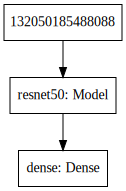

In [23]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [24]:
# Specifies the size of the validation set with test_size=TEST_SIZE. This controls how much of the data goes into the validation set. For example:
# If TEST_SIZE is 0.2, 20% of the data will go to X_val and y_val, and 80% will go to X_train and y_train.

# Ensures reproducibility with random_state=RANDOM_STATE, which makes sure that the dataset is split in the same way each time you run the code. 
# If the random_state is the same, you'll get the same split.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## <a id="52">Train the model</a>

We are now ready to train our model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
 2432/10000 [======>.......................] - ETA: 2:08:39 - loss: 8.0588 - acc: 0.4947

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']  # history accuracy
    val_acc = hist['val_acc']  # value accuracy
    loss = hist['loss']  # history loss 
    val_loss = hist['val_loss']  # value loss
    epochs = range(len(acc))  # Create epochs used range and length of accuracy.
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
# Returns two values: the loss (typically a measure of error) and an additional metric (in this case, accuracy).
# verbose=0 suppresses the output of the evaluation process.
score = model.evaluate(X_val, y_val, verbose=0)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
# Creates a boolean array where each element is True if the predicted class matches the corresponding true label (y_true), and False otherwise.
# returns the indices of the elements that are True (i.e., where the predictions were correct).
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]  # This creates a list of class names using a list comprehension.

# This line prints a classification report using the classification_report function from sklearn.metrics.
print(classification_report(y_true, predicted_classes, target_names=target_names))

# <a id="6">Prepare the submission</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

### Submission file

Let's prepare now the submission file.

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  


# <a id="8">References</a>

[1] Dogs vs. Cats Redux: Kernels Edition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
[2] ResNet pretrained models for Keras, https://www.kaggle.com/keras/resnet50  



